In [1]:
# ME EN 4650  Lab8:2D Conduction Lab    Ryan Dalby    
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from pandas.plotting import table
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 


In [2]:
# Define useful functions
mmhg_to_pa = lambda mmhg : mmhg*133.3 # Lambda function to covert mmHg to Pa
inh2o_to_pa = lambda inh2o : inh2o*249.04 # Lambda function to covert inH20 to Pa
in_to_m = lambda inch : inch*0.0254 # Lambda function to convert in to m
cm_to_m = lambda cm : cm/100 # Lambda function to convert in to m

# Define variabels
# t_data_filename = 'HeatPlateData.csv'
Tdata_filename = 'HeatPlateData_trimmed.csv'
single_pixel_area = 0.058 # in cm^2
single_pixel_length = np.sqrt(single_pixel_area) # In cm
P_E_left = '27.4' # W  
P_E_top =  'N/A (Cooling)' 
P_E_right = '34.5' # W
P_E_bottom = 'N/A (Insulated)'  
k_T6061_aluminum = 167 # W/(m*K)
t_plate = in_to_m(1/8) # Thickness of plate in m


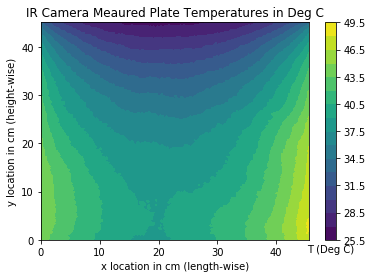

In [3]:
# Figure 1a 
# Read temperature data file and plot
Tdata = np.genfromtxt(Tdata_filename, delimiter=',')
Tdata = np.flipud(Tdata)
Tdata_size = np.shape(Tdata)
Tdata_M = Tdata_size[0]
Tdata_N = Tdata_size[1]
Tdata_L = single_pixel_length * Tdata_N # In cm
Tdata_H = single_pixel_length * Tdata_M # In cm
Tdata_x = np.linspace(0,Tdata_L,Tdata_N)
Tdata_y = np.linspace(0,Tdata_H,Tdata_M)
plt.figure()
plt.contourf(Tdata_x, Tdata_y, Tdata, 20)
cb = plt.colorbar()
cb.ax.set_xlabel('T (Deg C)')
plt.xlabel('x location in cm (length-wise)')
plt.ylabel('y location in cm (height-wise)')
plt.title('IR Camera Meaured Plate Temperatures in Deg C')
plt.show()

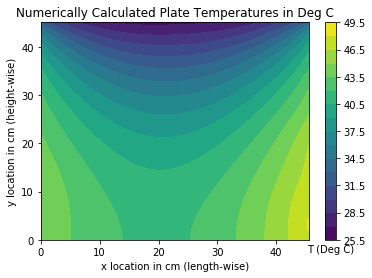

In [4]:
# Figure 1b 
Tnum = np.random.rand(Tdata_M,Tdata_N) # Initialize matrix for numerical simulation
Told = np.random.rand(Tdata_M,Tdata_N) # Matrix which will hold old guesses for gauss-seidel method
# Set boundary conditions
Tnum[:,0] = Tdata[:,0] # Left boundary 
Tnum[Tdata_M-1,:] = Tdata[Tdata_M-1,:] # Top boundary
Tnum[:,Tdata_N-1] = Tdata[:,Tdata_N-1] # Right boundary

# Gauss-seidel
lamb = 1.5 # Lambda parameter for gauss-seidel, will help tune convergence
tolerance = 1e-5 # The convergence tolerance for gauss-seidel
current_error = tolerance*10 # Define current error for gauss-seidel at value that will guarantee execution
# epochs = 0
while (current_error > tolerance):
    # epochs += 1
    Told[:] = Tnum
    for i in range(0, Tdata_M-1):
        for j in range(1, Tdata_N-1):
            if i == 0: # Bottom boundary
                Tnum[i,j] = (1/4) * (Tnum[i,j-1]+Tnum[i,j+1]+2*Tnum[i+1,j]) 
            else:
                Tnum[i,j] = (1/4) * (Tnum[i,j-1]+Tnum[i,j+1]+Tnum[i-1,j]+Tnum[i+1,j]) 
    Tnum = lamb*Tnum + (1-lamb)*Told
    current_error = np.nanmax(np.abs(Tnum-Told)/Tnum)
    # print(epochs)
    # print(current_error)
plt.figure()
plt.contourf(Tdata_x, Tdata_y, Tnum, 20)
cb = plt.colorbar()
cb.ax.set_xlabel('T (Deg C)')
plt.xlabel('x location in cm (length-wise)')
plt.ylabel('y location in cm (height-wise)')
plt.title('Numerically Calculated Plate Temperatures in Deg C')
plt.show()

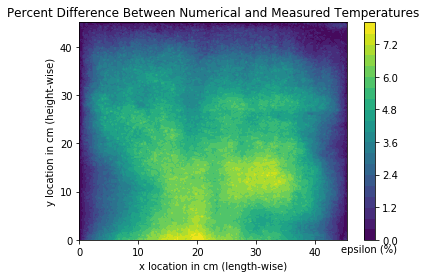

In [5]:
# Figure 1c
epsilon = (np.abs(Tdata-Tnum)/Tdata)*100 # Percent difference between numerical simulation and IR camera measured termperatures in percent
plt.figure()
plt.contourf(Tdata_x, Tdata_y, epsilon, 20)
cb = plt.colorbar()
cb.ax.set_xlabel('epsilon (%)')
plt.xlabel('x location in cm (length-wise)')
plt.ylabel('y location in cm (height-wise)')
plt.title('Percent Difference Between Numerical and Measured Temperatures')
plt.show()


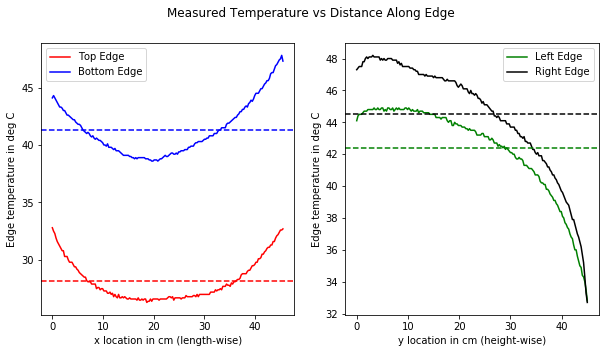

In [6]:
# Figure 1d
Tdata_top = Tdata[Tdata_M-1,:]
Tdata_top_mean = np.mean(Tdata_top) 
Tdata_bottom = Tdata[0,:]
Tdata_bottom_mean = np.mean(Tdata_bottom) 
Tdata_right = Tdata[:,Tdata_N-1]
Tdata_right_mean = np.mean(Tdata_right) 
Tdata_left = Tdata[:,0]
Tdata_left_mean = np.mean(Tdata_left) 
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Measured Temperature vs Distance Along Edge')
ax1.plot(Tdata_x, Tdata_top, 'r')
ax1.plot(Tdata_x, Tdata_bottom, 'b')
ax1.set_xlabel('x location in cm (length-wise)')
ax1.set_ylabel('Edge temperature in deg C')
ax1.legend(['Top Edge', 'Bottom Edge'])
ax2.plot(Tdata_y, Tdata_left, 'g')
ax2.plot(Tdata_y, Tdata_right, 'k')
ax2.set_xlabel('y location in cm (height-wise)')
ax2.set_ylabel('Edge temperature in deg C')
ax2.legend(['Left Edge', 'Right Edge'])

# Plot mean temperature as a line with no label on legend
ax1.axhline(Tdata_top_mean, color='r', linestyle='--')
ax1.axhline(Tdata_bottom_mean, color='b', linestyle='--')
ax2.axhline(Tdata_left_mean, color='g', linestyle='--')
ax2.axhline(Tdata_right_mean, color='k', linestyle='--')
plt.show()

Heat Transfer Rates and Power For Flat Plate Edges


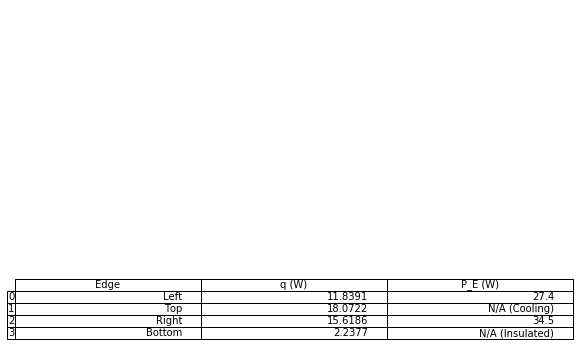

In [7]:
# Figure 1e
# Calculate q
delta_x = cm_to_m(Tdata_L) # m
delta_y = cm_to_m(Tdata_H) # m
qflux_left = -k_T6061_aluminum*(-Tdata[:,2] + 4*Tdata[:,1] - 3*Tdata[:,0])/(2*delta_x)
q_left = t_plate*np.trapz(qflux_left, x=Tdata_y)
qflux_right = -k_T6061_aluminum*(3*Tdata[:,Tdata_N-1] - 4*Tdata[:,Tdata_N-2] + Tdata[:,Tdata_N-3])/(2*delta_x)
q_right = t_plate*np.trapz(qflux_right, x=Tdata_y)
qflux_bottom = -k_T6061_aluminum*(-Tdata[2,:] + 4*Tdata[1,:] - 3*Tdata[0,:])/(2*delta_y)
q_bottom = t_plate*np.trapz(qflux_bottom, x=Tdata_x)
qflux_top = -k_T6061_aluminum*(3*Tdata[Tdata_M-1,:] - 4*Tdata[Tdata_M-2,:] + Tdata[Tdata_M-3,:])/(2*delta_y)
q_top = t_plate*np.trapz(qflux_top, x=Tdata_x)

# Will look at magnitude of q
q_table_data = {'Edge': ['Left', 'Top', 'Right', 'Bottom'], 'q (W)':[np.abs(q_left),np.abs(q_top),np.abs(q_right),np.abs(q_bottom)], 'P_E (W)':[P_E_left,P_E_top,P_E_right,P_E_bottom]} 
q_table = pd.DataFrame(q_table_data, columns=['Edge', 'q (W)', 'P_E (W)'])
print('Heat Transfer Rates and Power For Flat Plate Edges')
fig, ax = plt.subplots(1,1, figsize=(10,5)) 
ax.axis('off')
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
q_table = q_table.round(decimals=4)
table(ax, q_table) 
plt.show()


In [8]:
# 2a
avg_epsilon = np.mean(epsilon)
max_epsilon_idx = np.unravel_index(np.argmax(epsilon), epsilon.shape)
max_epsilon = epsilon[max_epsilon_idx]

max_epsilon_x = Tdata_x[max_epsilon_idx[1]]
max_epsilon_y = Tdata_y[max_epsilon_idx[0]]
print('The average epsilon is {:.2f}%\n The max epsilon is {:.2f}% at x = {:.2f}cm and y = {:.2f}cm'.format(avg_epsilon, max_epsilon, max_epsilon_x, max_epsilon_y))


The average epsilon is 3.74%
 The max epsilon is 7.98% at x = 20.82cm and y = 0.00cm


In [9]:
# 2b
Tdata_left_pcterror = (2*np.std(Tdata_left)/np.mean(Tdata_left))*100 # 95% gaussian error
print('The 95% error of the left edge is {:.2f}%'.format(Tdata_left_pcterror))
Tdata_top_pcterror = (2*np.std(Tdata_top)/np.mean(Tdata_top))*100 # 95% gaussian error
print('The 95% error of the top edge is {:.2f}%'.format(Tdata_top_pcterror))
Tdata_right_pcterror = (2*np.std(Tdata_right)/np.mean(Tdata_right))*100 # 95% gaussian error
print('The 95% error of the right edge is {:.2f}%'.format(Tdata_right_pcterror))
Tdata_bottom_pcterror = (2*np.std(Tdata_bottom)/np.mean(Tdata_bottom))*100 # 95% gaussian error
print('The 95% error of the bottom edge is {:.2f}%'.format(Tdata_bottom_pcterror))


The 95% error of the left edge is 13.60%
The 95% error of the top edge is 12.57%
The 95% error of the right edge is 15.66%
The 95% error of the bottom edge is 11.27%


In [10]:
# 2c
heat_eff = 0.95 # Heating efficiency 
cooling_eff = 0.15 # Heating efficiency 
print('It is estimated that to heat the left edge {:.2f}W of power was used. The actual measured power was {:s}W.'.format(np.abs(q_left)*(1/heat_eff), P_E_left))
print('It is estimated that to cool the top edge {:.2f}W of power was used. The actual measured power was not measured.'.format(np.abs(q_top)*(1/cooling_eff)))
print('It is estimated that to heat the right edge {:.2f}W of power was used. The actual measured power was {:s}W.'.format(np.abs(q_right)*(1/heat_eff), P_E_right))


It is estimated that to heat the left edge 12.46W of power was used. The actual measured power was 27.4W.
It is estimated that to cool the top edge 120.48W of power was used. The actual measured power was not measured.
It is estimated that to heat the right edge 16.44W of power was used. The actual measured power was 34.5W.
